In [1]:
! pip install scikit-plot

In [43]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import scikitplot as skplot

In [3]:
# reading the csv 
cc_org = pd.read_csv("CC GENERAL.csv")
cc_org.shape

(8950, 18)

In [4]:
# first look at the data set
cc_org.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
# looking at the data set and the data type 
cc_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [6]:
# looking for missing value 
# detected missing values for "minimum payments" and "credit_limit"
cc_org.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [7]:
cc_org.isna().mean()*100

CUST_ID                             0.000000
BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.011173
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    3.497207
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
dtype: float64

In [24]:
cc_org.describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


In [8]:
# drop "cust_id" since it doesn't have any role in determining the cluster and is not numeric
cc_org = cc_org.drop(columns = "CUST_ID")

In [9]:
# change all missing value under "minimum payments" to median
# we chose the median because the mean was significantly higher and seemed not appropriate
cc_org['MINIMUM_PAYMENTS'].fillna(cc_org['MINIMUM_PAYMENTS'].median(), inplace=True)

In [10]:
# Just 1 value is missing at CREDIT_LIMIT feature, we can simply drop it and never think about it again.
cc_clean = cc_org.dropna()

In [25]:
# lower case all column names
cc_clean.columns = cc_clean.columns.str.lower()

In [26]:
# verify that we don't have any missing values left
cc_clean.isna().sum()

balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

In [12]:
# since our dataset is too big for hclust, we are gonna pick a sample which include 1500 rows
cc_new = cc_clean.sample(n=1500)

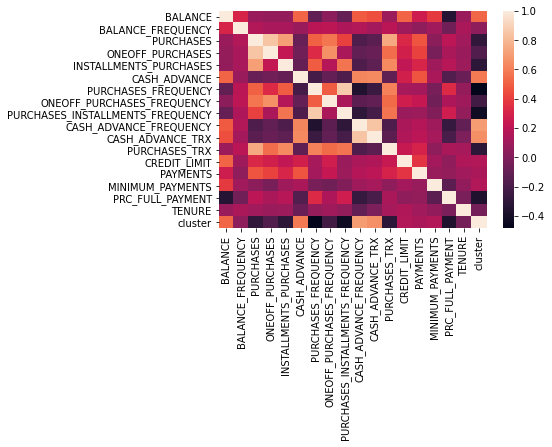

In [27]:
# correlations
cc_corr = cc_new.corr()
sns.heatmap(cc_corr)

In [14]:
# using standardscaler to reduce the distance of each variable
sc = StandardScaler()
xs = sc.fit_transform(cc_new)
X = pd.DataFrame(xs, index=cc_new.index, columns=cc_new.columns)

In [15]:
# hclust
# going to do euclidean, cosine and cityblock distance
# no jaccard since this is more for categorical problems
diste = pdist(X.values)
distc = pdist(X.values, metric='cosine')
distm = pdist(X.values, metric ='cityblock')


hclust_e = linkage(diste)
hclust_c = linkage(distc)
hclust_m = linkage(distm)

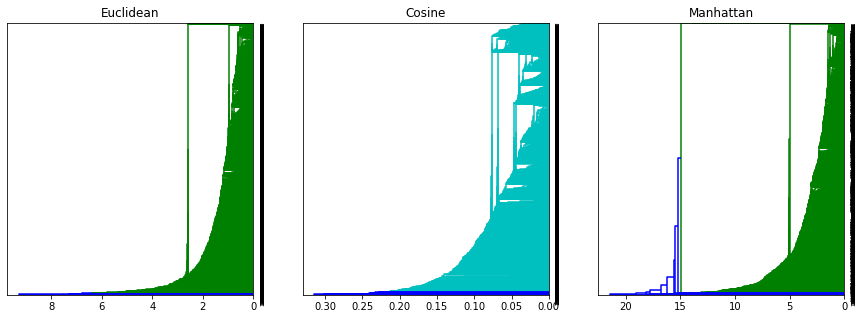

In [16]:
#both plot
LINKS = [hclust_e, hclust_c, hclust_m]
TITLE = ['Euclidean','Cosine','Manhattan']

plt.figure(figsize=(15,5))

#loop and build our plot
for i, m in enumerate(LINKS):
  plt.subplot(1,3,i+1)
  plt.title(TITLE[i])
  dendrogram(m,
             #labels = ps.index
             leaf_rotation=90,
             # leaf_font_size=10,
             orientation='left')
plt.show()

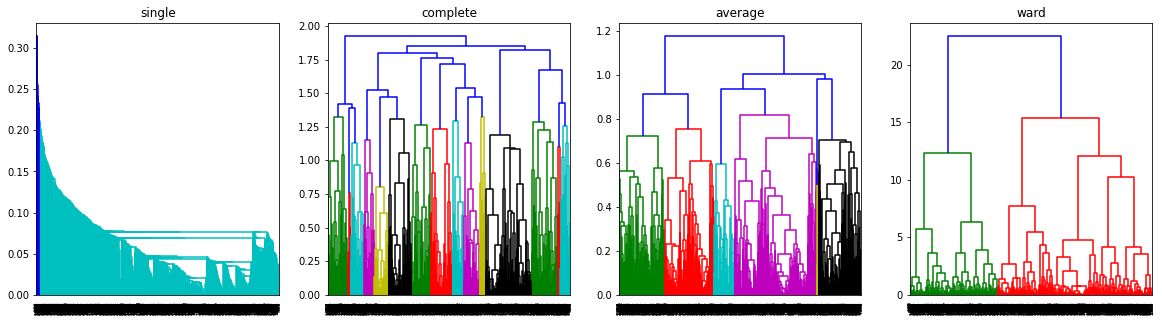

In [18]:
# picking cosine ans using 4 different methods to detect the clusters
METHODS = ['single', 'complete', 'average','ward']
plt.figure(figsize=(20,5))

for i, m in enumerate(METHODS):
  plt.subplot(1,4,i+1)
  plt.title(m)
  dendrogram(linkage(distc, method=m),
             leaf_rotation=90)
plt.show()

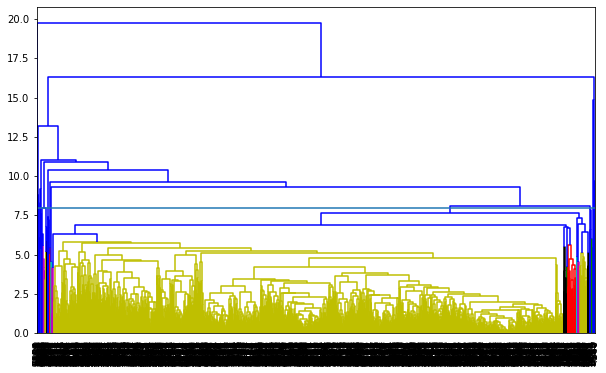

In [19]:
# cosine and average seems like a good combination, so let's take a closer look
plt.figure(figsize=(10, 6))

avg = linkage(X.values, method="average")
dendrogram(avg,
          labels = X.index,
          leaf_rotation=90,
          leaf_font_size=10, color_threshold=6)

plt.axhline(y=8)
plt.show()

In [40]:
# using cosine + complete
# the labels with 4 clusters
labs = fcluster(linkage(distc, method='average'), 4, criterion='maxclust')

# confirm
np.unique(labs)

array([1, 2, 3, 4], dtype=int32)

In [41]:
# add a cluster column to the stocks data set
cc_new['cluster'] = labs

#How many credit card per cluster assignment?
cc_new.cluster.value_counts(dropna=False,sort=False)

1    589
2    636
3     13
4    262
Name: cluster, dtype: int64

In [44]:
# Select the number of components:our data in the lower dimensions explains 95% of variacne of our orginal data
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(cc_clean)

In [45]:
# Use KMeans clustering algorithm to extracts clusters of information
K_model = [KMeans(n_clusters=k,random_state=820).fit(X_pca) for k in range(1,10)]

Text(0.5, 1.0, 'Inertia Method')

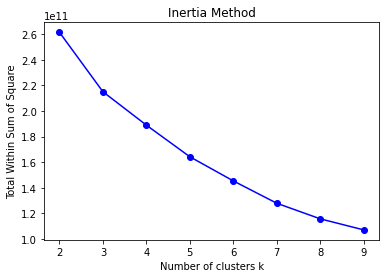

In [46]:
# Inertia
inertia_M = [model.inertia_ for model in K_model[1:10]]
plt.plot(range(2,10),inertia_M,"bo-")
plt.xlabel("Number of clusters k")
plt.ylabel("Total Within Sum of Square")
plt.xticks([2,3,4,5,6,7,8,9])
plt.title("Inertia Method")

# no real elbow is shown

([<matplotlib.axis.XTick at 0x7fa143ceb8d0>,
 <a list of 8 Text major ticklabel objects>)

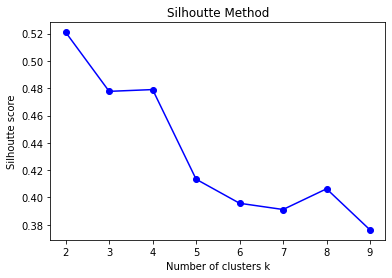

In [47]:
# Silhoutte
silhoutte_scores = [silhouette_score(X_pca,model.labels_) for model in K_model[1:10]]
plt.plot(range(2,10),silhoutte_scores,"bo-")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhoutte score")
plt.title("Silhoutte Method")
plt.xticks([2,3,4,5,6,7,8,9])

# k=2 gives us the highest silhouette score - Qiqi
# K=4 seems like a good option - just 2 clusters could be not enough, also 2 clusters seems really categorical (Hclust = jaccard?!) - Paula

In [51]:
# another method: KMeans 
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(cc_clean)

# Kmeans for 2 to 8 clusters
KS = range(2, 10)

# storage
inertia = []
silo = []

for k in KS:
  km = KMeans(k)
  km.fit(X_pca)
  labs = km.predict(X_pca)
  inertia.append(km.inertia_)
  silo.append(silhouette_score(X_pca, labs))

print(silo)

[0.5210017814110539, 0.4781857477423221, 0.4788493780143433, 0.4210472281768214, 0.3878142456116856, 0.3897282151747725, 0.40546898489063227, 0.3756250825522104]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


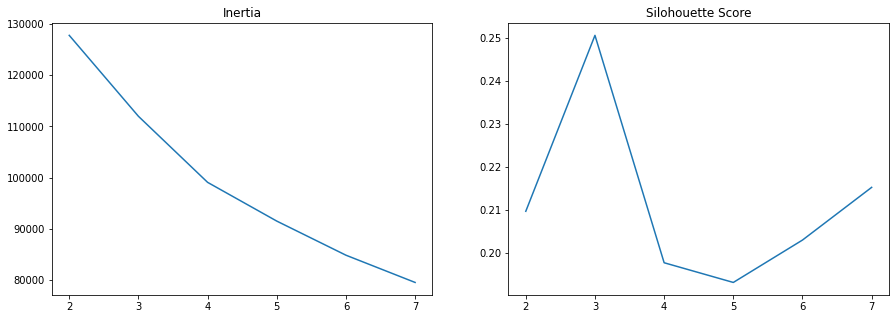

In [49]:
#plot 
plt.figure(figsize=(15,5))


plt.subplot(1, 2, 1)
plt.title("Inertia")
sns.lineplot(KS, inertia)

plt.subplot(1, 2, 2)
plt.title("Silohouette Score")
sns.lineplot(KS, silo)

plt.show()